<a href="https://colab.research.google.com/github/oscaryas/MAT1510/blob/main/DinoV2%20Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers torch

In [ ]:
import torch
import requests
from PIL import Image
from transformers import AutoModelForImageClassification, AutoImageProcessor
import matplotlib.pyplot as plt

image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224",
    use_fast=True,
)
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    dtype=torch.float32,
    device_map="auto",
    attn_implementation="sdpa"
)
# url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = image_processor(image, return_tensors="pt").to(model.device)

# with torch.no_grad():
#   logits = model(**inputs).logits
# predicted_class_id = logits.argmax(dim=-1).item()

class_labels = model.config.id2label
# predicted_class_label = class_labels[predicted_class_id]
# print(f"The predicted class label is: {predicted_class_label}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
print(model.modules)


<bound method Module.modules of ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, 

In [ ]:
activations = {}
handles = []

def make_hooks(layer_id):
  def fw_hooks(module, input, output):
    print(output.shape)
    output = output[:,1:,:]
    activations[layer_id] = output

  return fw_hooks

layer_idx = 0
for module in model.modules():
  # module.register_forward_hooks(make_hooks(layer_idx))
  try:
    module.intermediate
    hooks = make_hooks(layer_idx)
    module.register_forward_hook(hooks)
    handles.append(hooks)

    # print(layer_idx)
    layer_idx += 1

  except AttributeError:
    continue


In [ ]:
handles

[<function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>,
 <function __main__.make_hooks.<locals>.fw_hooks(module, input, output)>]

In [ ]:
print(activations)

{}


In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x686 at 0x780BEE29B530>


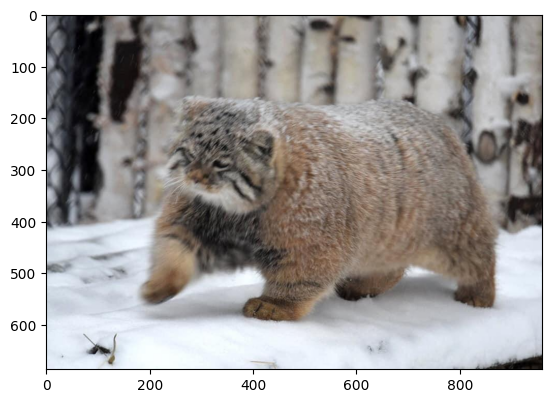

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
inputs = image_processor(image, return_tensors="pt").to(model.device)

In [ ]:
# inputs

In [ ]:
logits = model(**inputs).logits
predicted_class_id = logits.argmax(dim=-1).item()

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [ ]:
# activations

In [ ]:
activations[0].shape #[batch_size, tokens, embeddings]

torch.Size([1, 196, 768])

In [ ]:
pcas = {}
keep_top_frac = 0.7
for i, layer_idx in enumerate(activations.keys()):
  X = activations[layer_idx]
  X = X[0]
  if X.dim() == 3:
      X = X.reshape(-1, X.shape[-1])

  X_centered = (X - X.mean(dim=0, keepdim=True))
  U, S, V = torch.pca_lowrank(X_centered, q=8)   # V: [d_model, 3]

  projected_tokens = X_centered @ V[:, 2:5]       # [N, 3]
  normed = projected_tokens / projected_tokens.norm(dim=1, keepdim=True)
  normed = normed[:, [2, 0, 1]]

  pcas[layer_idx] = normed.T.detach()


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
pcas[0].shape

KeyError: 0

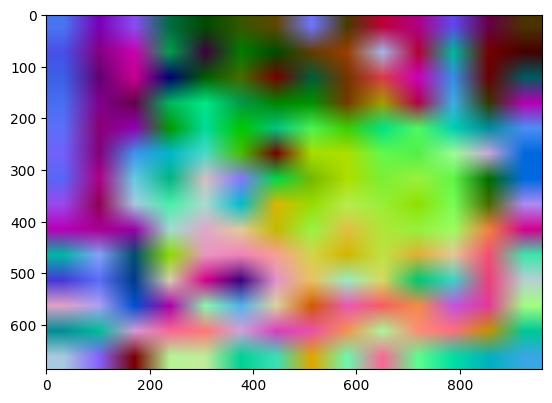

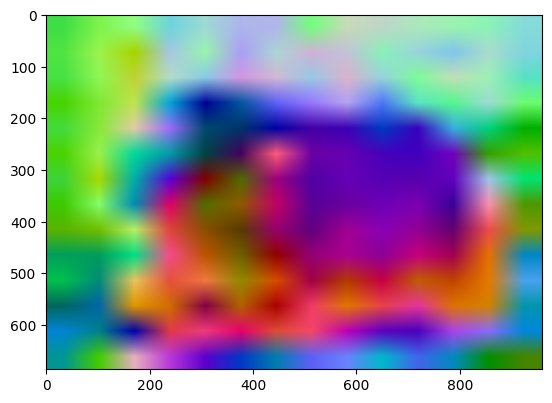

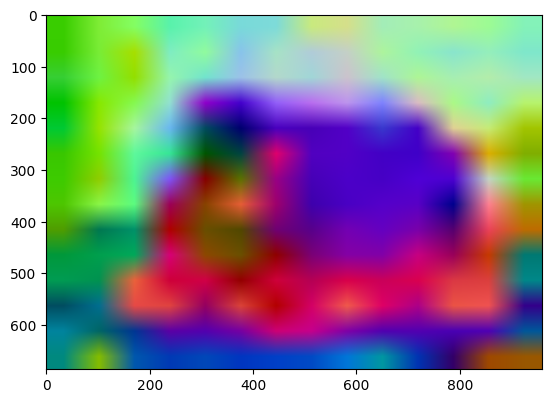

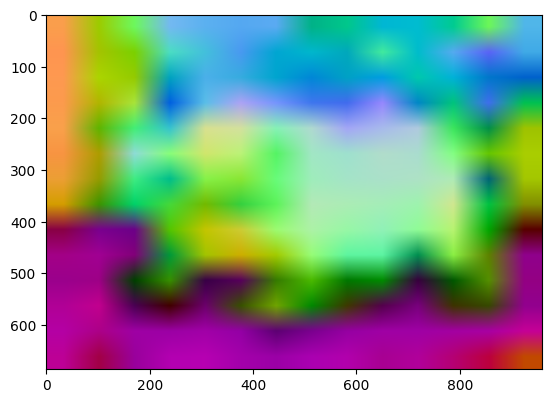

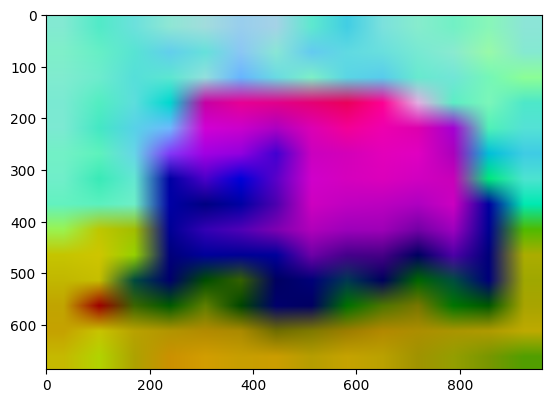

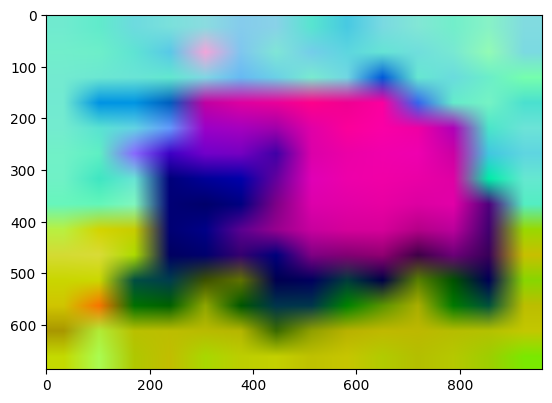

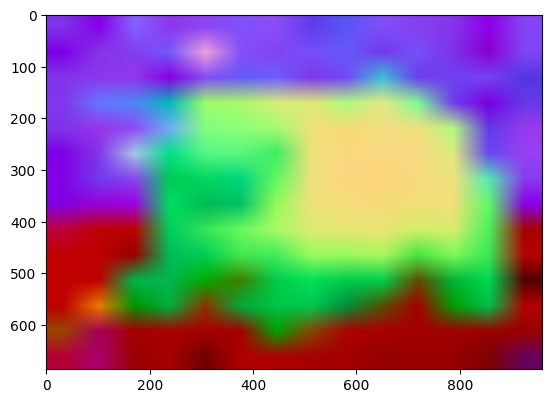

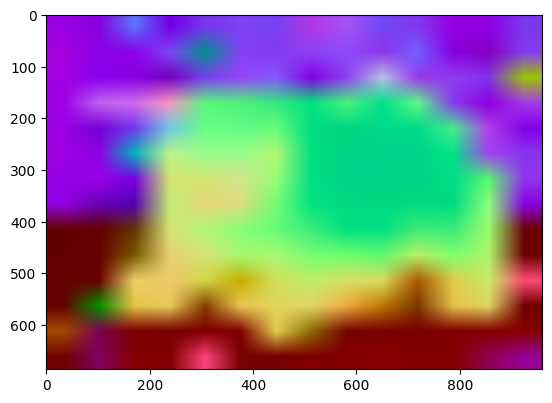

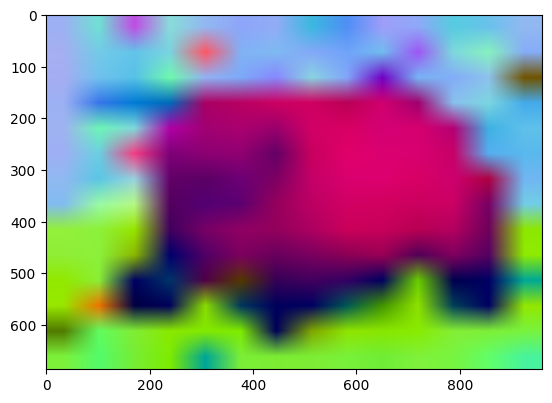

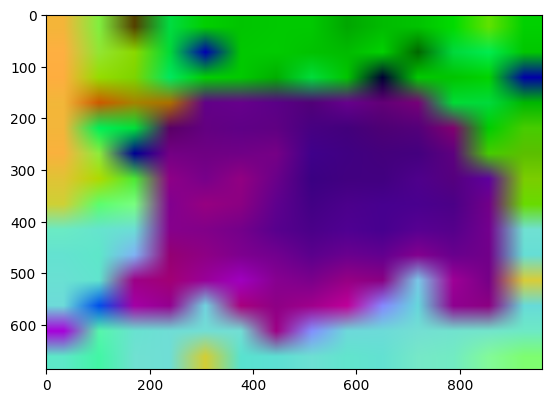

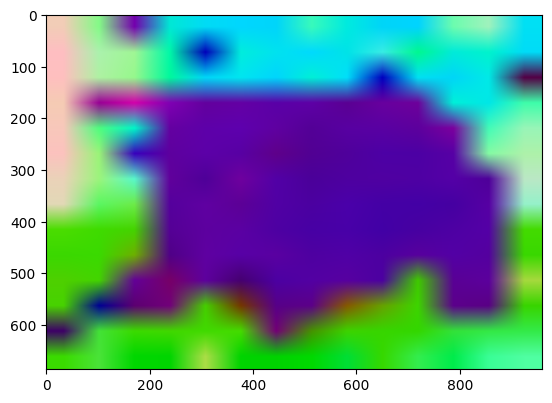

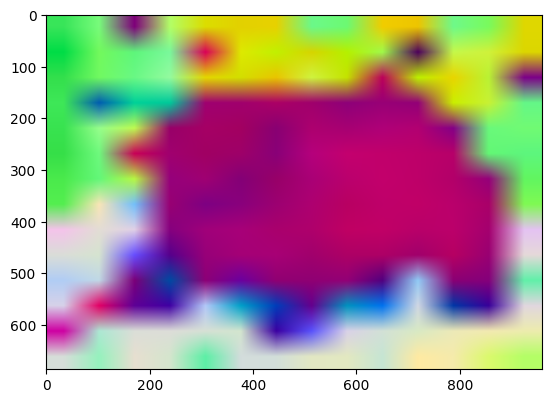

In [ ]:
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image

grid_hw=(14,14)   # (H_patches, W_patches)
patch_size=16    # pixels per patch
out_hw=(224,224)
H_p, W_p = grid_hw
thresh = 0.2


for i, layer_idx in enumerate(pcas.keys()):
  grid = pcas[i].T
  mins = grid.min(dim=0).values
  maxs = grid.max(dim=0).values
  grid = (grid - mins) / (maxs - mins + 1e-8)
  grid = grid.reshape(H_p, W_p, 3).permute(2,0,1).unsqueeze(0)  # (1,3,H_p,W_p)
  grid[grid < thresh] = 0
  up = F.interpolate(grid, size=(686, 960), mode='bilinear', align_corners = False)
  img = (up.clamp(0,1)*255).to(torch.uint8).squeeze(0)
  img = img.cpu()
  pil_img = to_pil_image(img)
  plt.imshow(pil_img)
  plt.show()

adsifaopdsifh

In [ ]:
import requests
from transformers import TorchAoConfig, AutoImageProcessor, AutoModelForImageClassification
from torchao.quantization import Int4WeightOnlyConfig
import torch
from PIL import Image

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-giant-imagenet1k-1-layer')

quant_config = Int4WeightOnlyConfig(group_size=128)
quantization_config = TorchAoConfig(quant_type=quant_config)

model = AutoModelForImageClassification.from_pretrained(
    'facebook/dinov2-giant-imagenet1k-1-layer',
    dtype=torch.float32,
    device_map="auto",
)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7F7BF443C9E0>


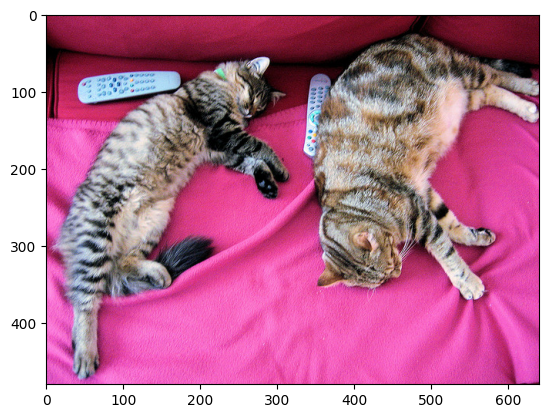

In [ ]:
print(image)
plt.imshow(image)

In [ ]:
activations = {}
handles = []

def make_hooks(layer_id):
  def fw_hooks(module, input, output):
    print(output.shape)
    output = output[:,1:,:]
    activations[layer_id] = output

  return fw_hooks

layer_idx = 0
for module in model.modules():

  # module.register_forward_hooks(make_hooks(layer_idx))
  try:
    module.norm1
    # print(module)
    hooks = make_hooks(layer_idx)
    try:
      module.register_forward_hook(hooks)

    except AttributeError:
      print('fuck')

    handles.append(hooks)

    # print(layer_idx)
    layer_idx += 1

  except AttributeError:
    continue


In [ ]:
print(model.modules)

In [ ]:
inputs = processor(images=image, return_tensors="pt").to(model.device)
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
torch.Size([1, 257, 1536])
t

In [ ]:
activations

In [ ]:
pcas = {}
keep_top_frac = 0.7
for i, layer_idx in enumerate(activations.keys()):
  X = activations[layer_idx]
  X = X[0]
  if X.dim() == 3:
      X = X.reshape(-1, X.shape[-1])

  X_centered = (X - X.mean(dim=0, keepdim=True))
  U, S, V = torch.pca_lowrank(X_centered, q=8)   # V: [d_model, 3]

  projected_tokens = X_centered @ V[:, 1:4]       # [N, 3]
  normed = projected_tokens / projected_tokens.norm(dim=1, keepdim=True)
  normed = normed[:, [2, 0, 1]]
  normed[normed < 0.4] = 0
  pcas[layer_idx] = normed.T.detach()


In [ ]:
print(pcas)

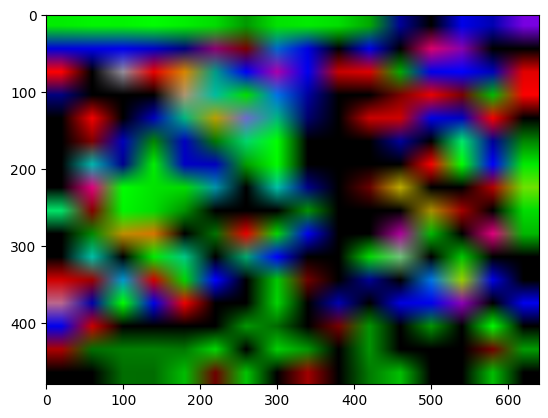

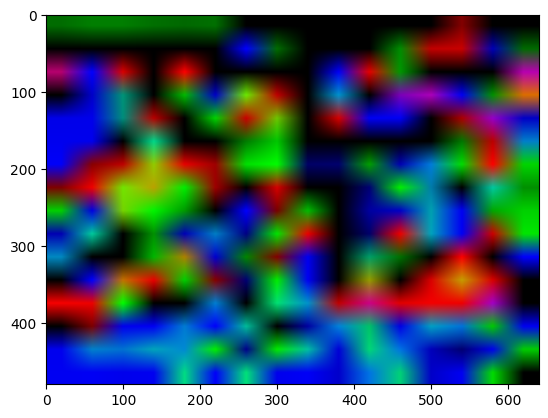

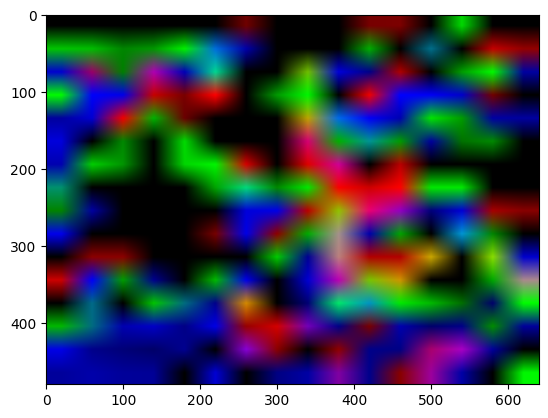

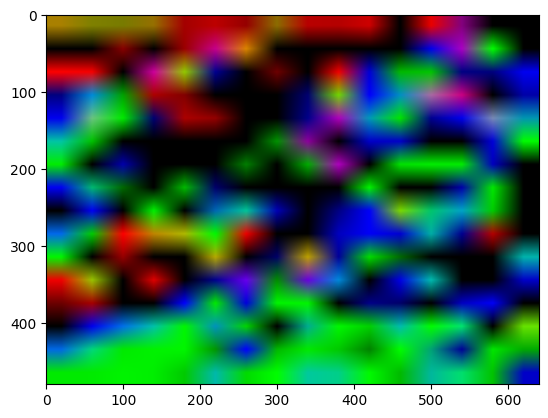

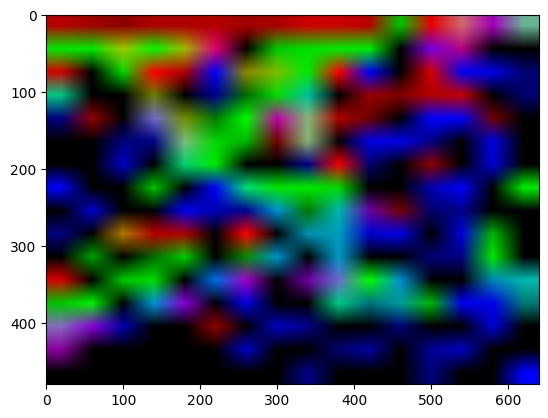

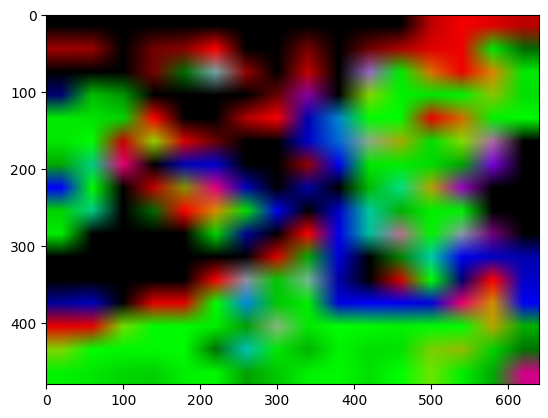

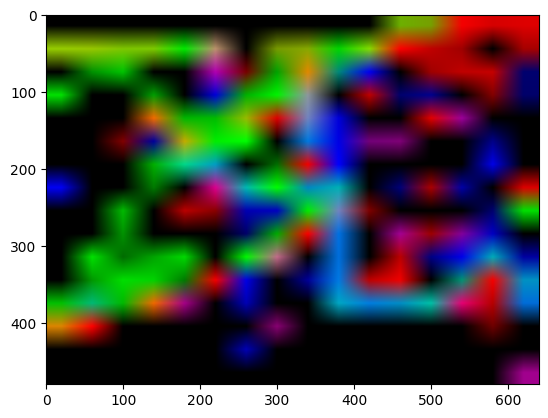

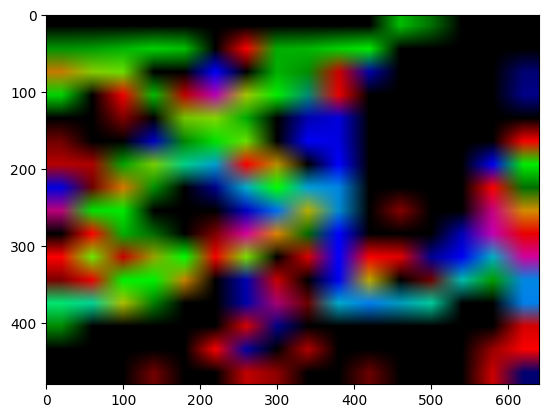

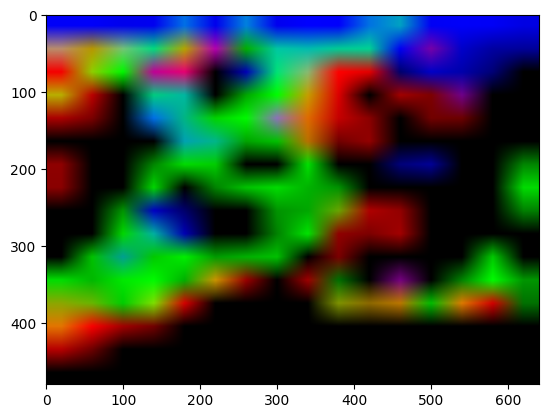

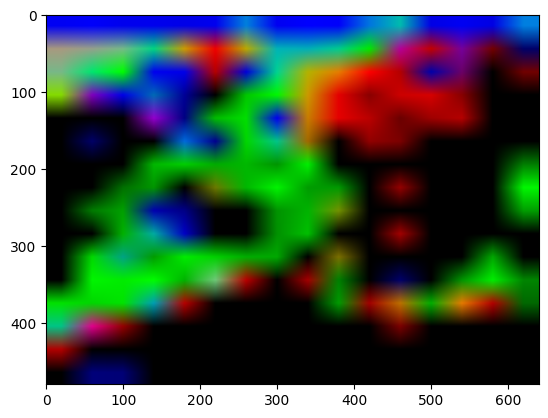

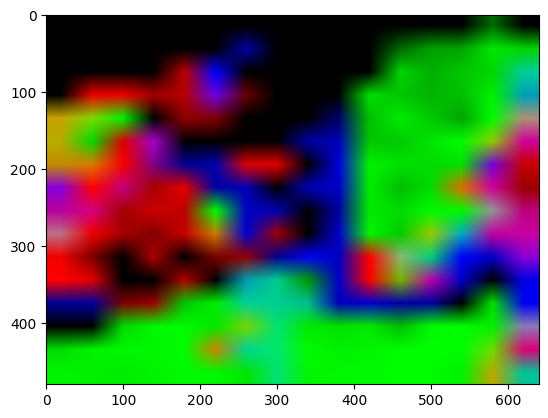

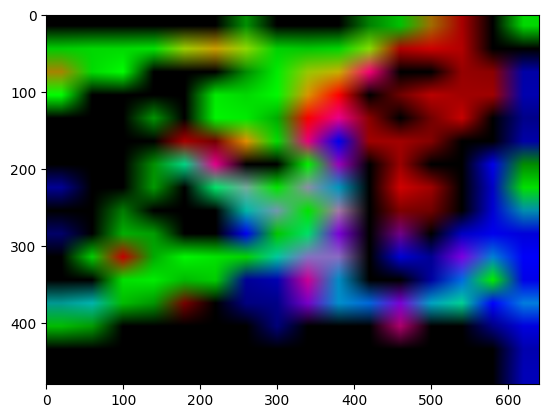

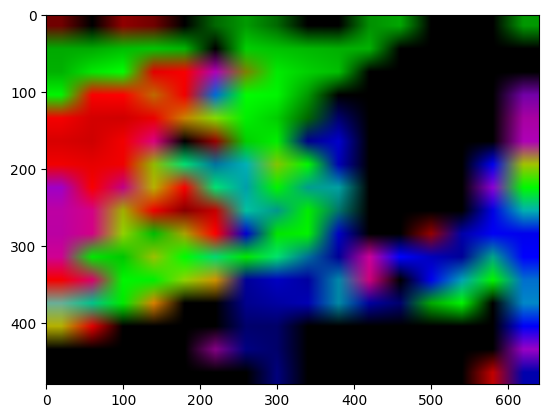

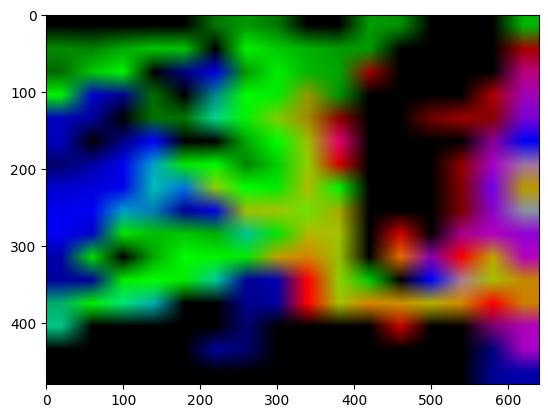

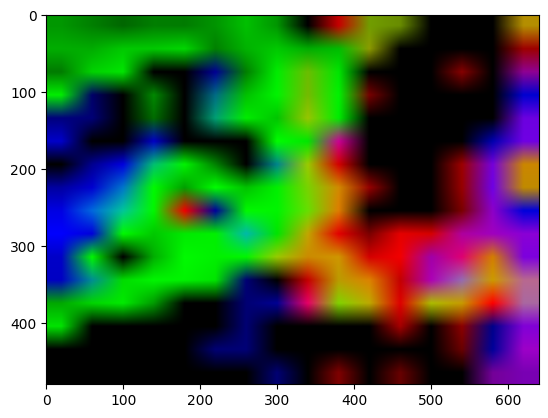

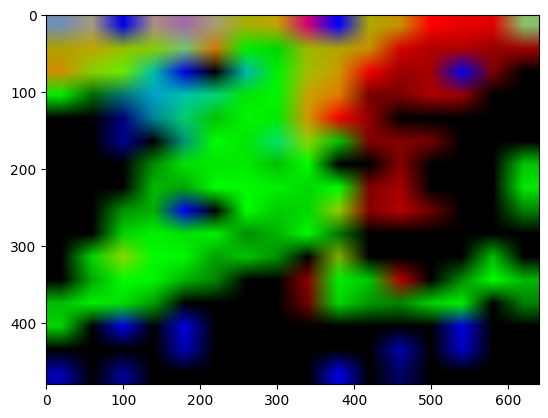

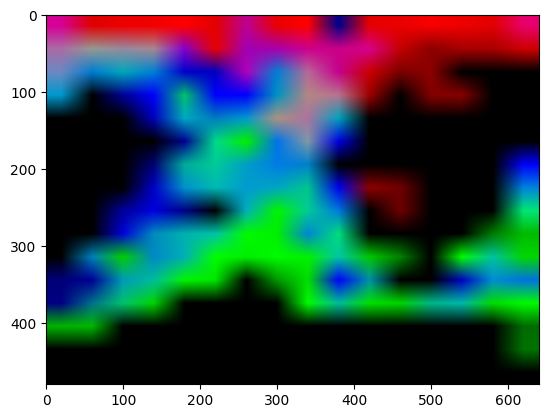

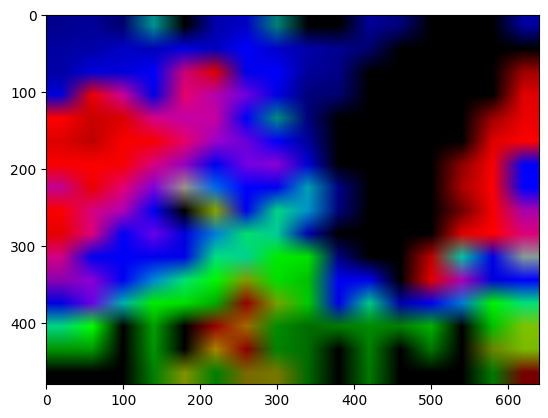

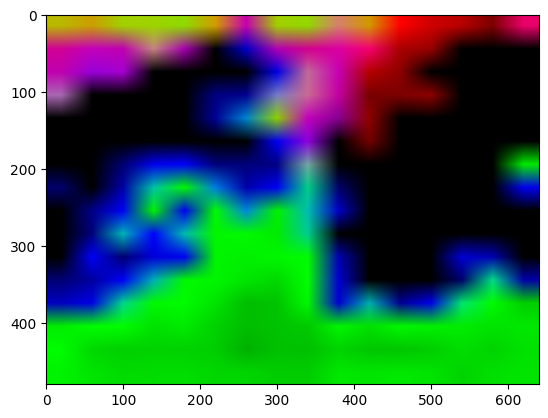

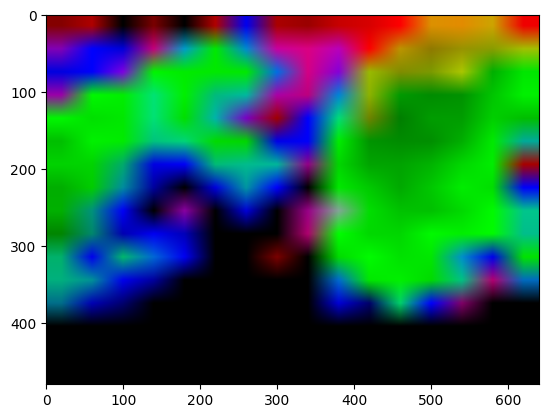

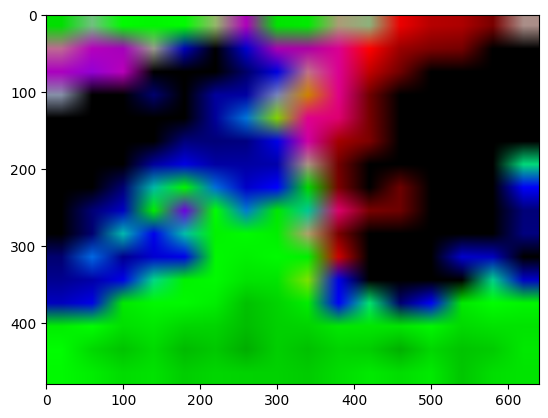

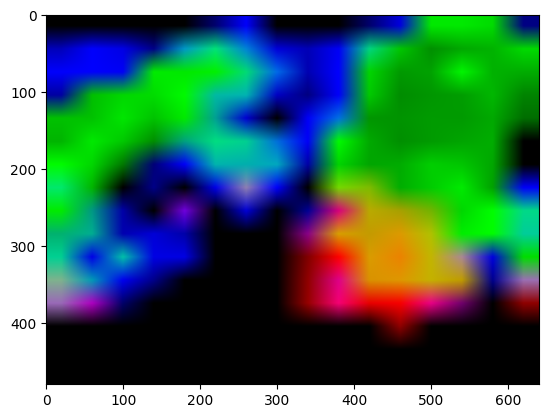

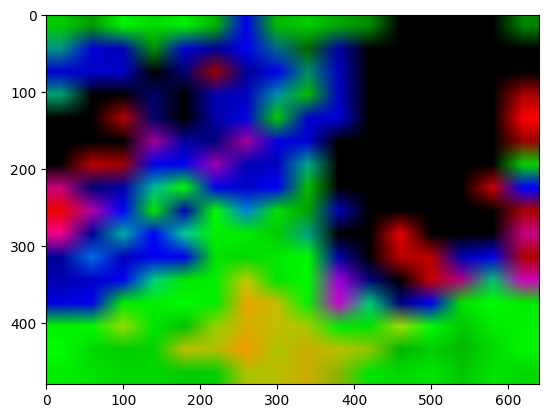

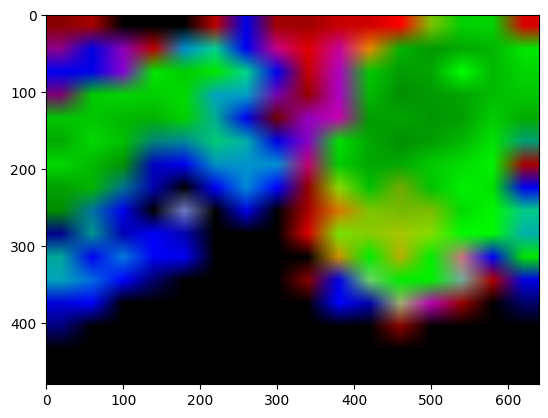

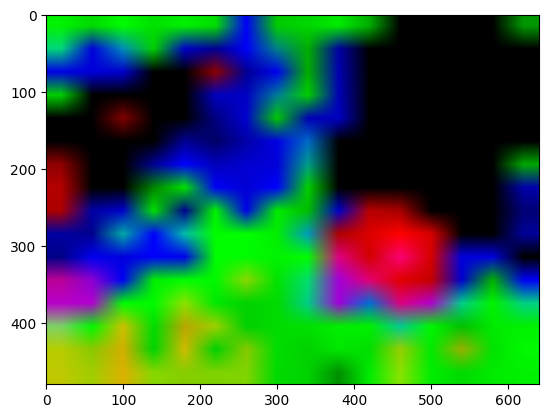

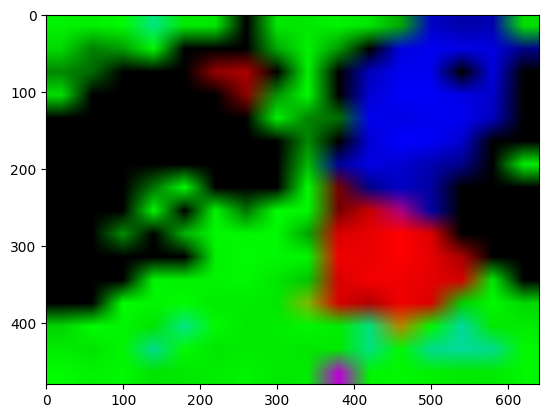

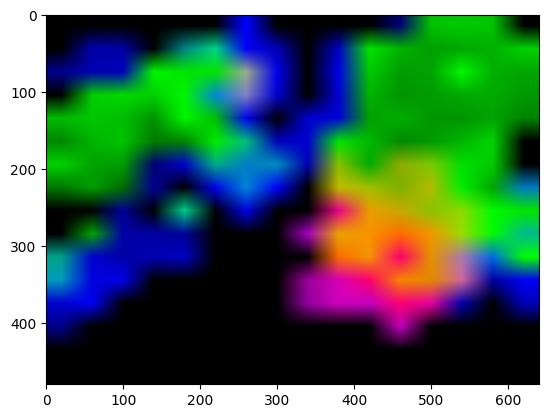

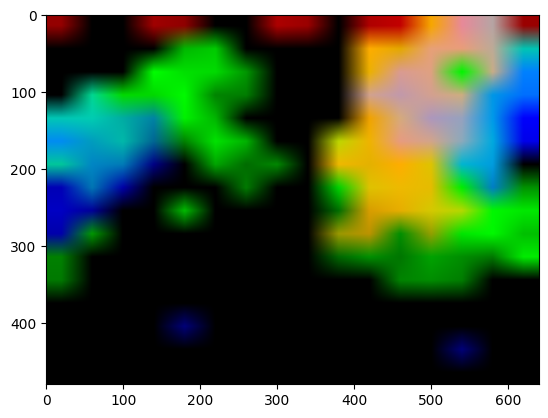

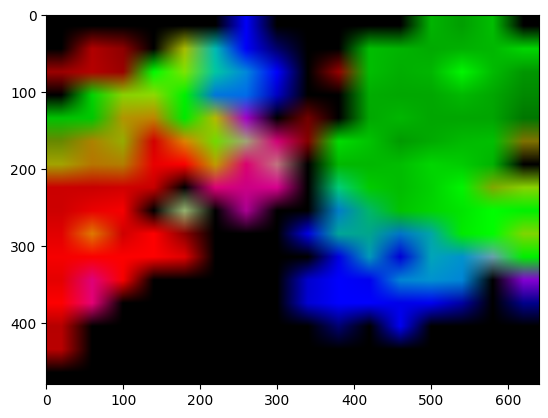

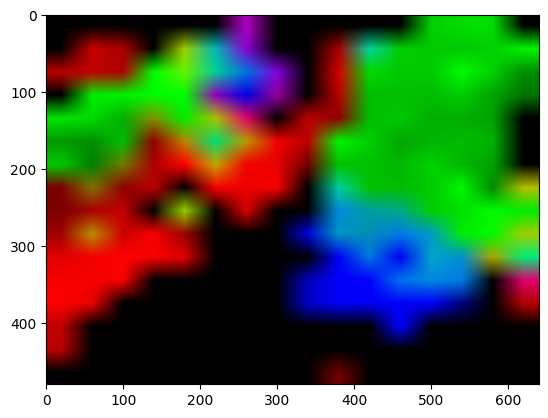

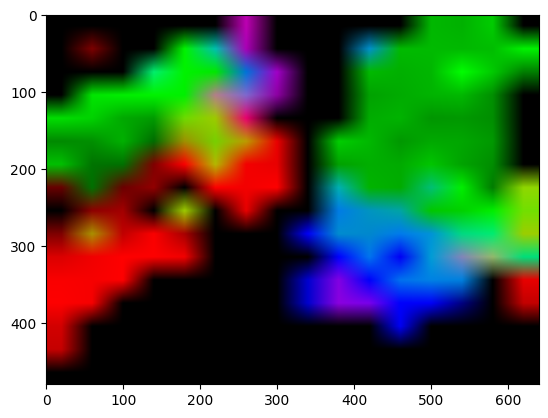

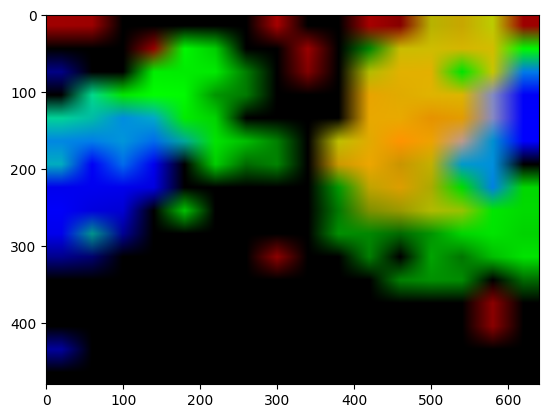

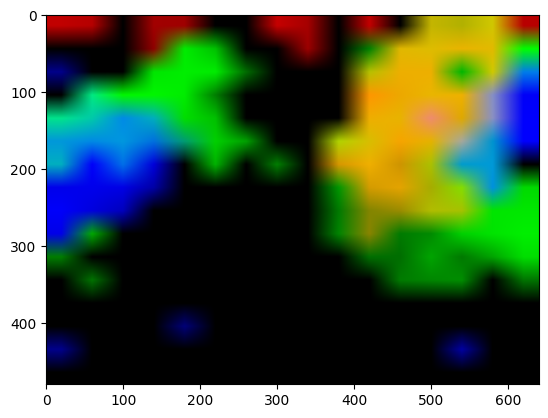

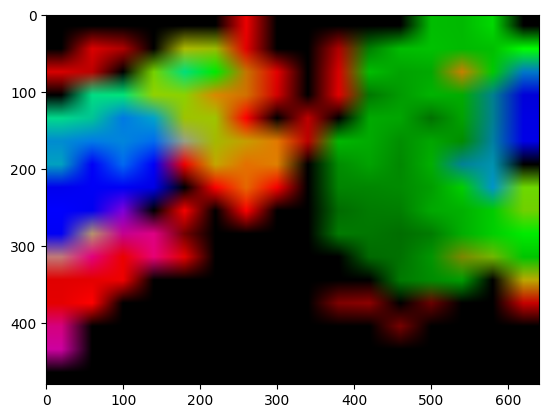

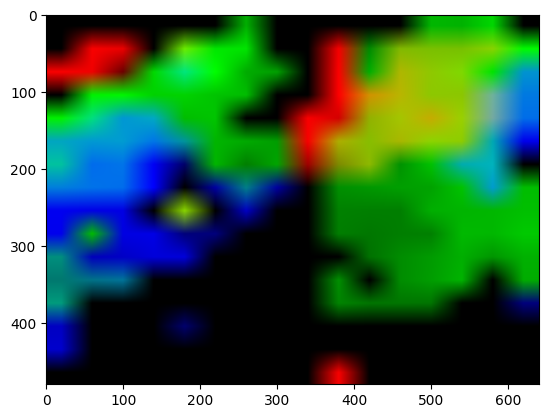

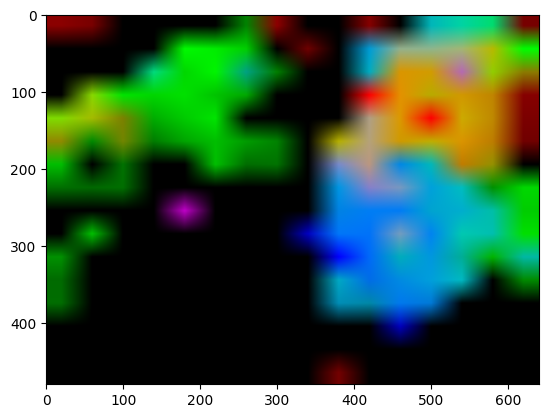

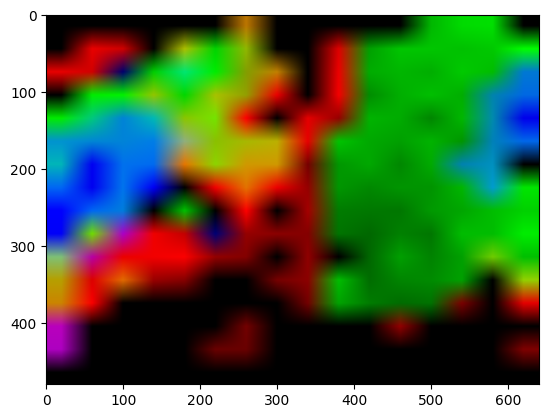

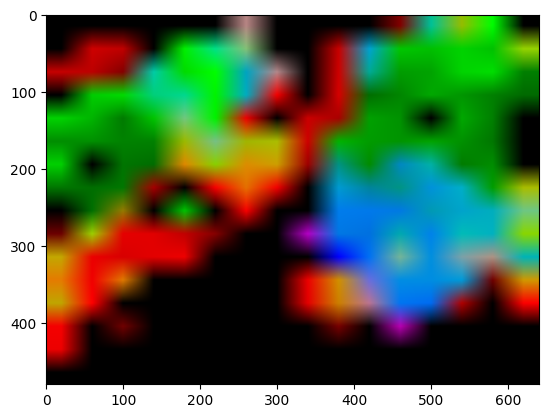

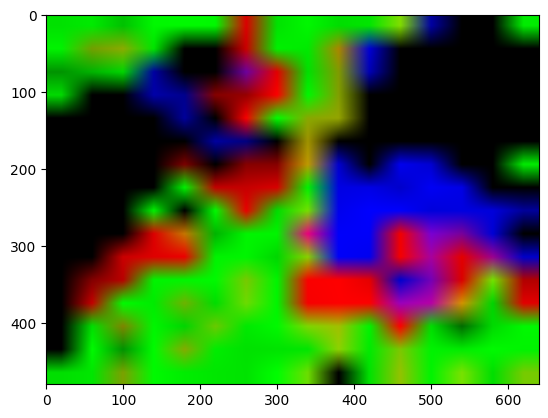

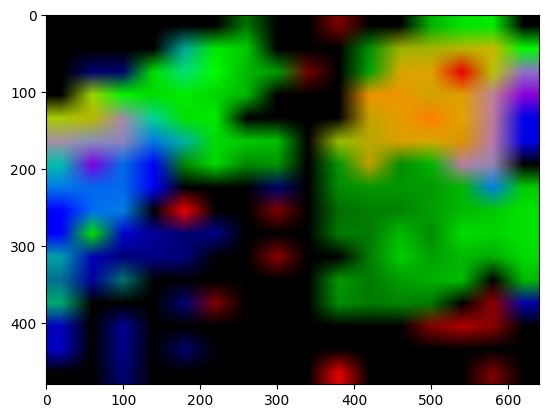

In [ ]:
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

grid_hw=(16,16)   # (H_patches, W_patches)
patch_size=16    # pixels per patch
out_hw=(224,224)
H_p, W_p = grid_hw
thresh = 0.7


for i, layer_idx in enumerate(pcas.keys()):
  grid = pcas[i].T
  mins = grid.min(dim=0).values
  maxs = grid.max(dim=0).values
  grid = (grid - mins) / (maxs - mins + 1e-8)
  grid = grid.reshape(H_p, W_p, 3).permute(2,0,1).unsqueeze(0)  # (1,3,H_p,W_p)
  up = F.interpolate(grid, size=(480, 640), mode='bilinear', align_corners = False)
  img = (up.clamp(0,1)*255).to(torch.uint8).squeeze(0)
  img = img.cpu()
  pil_img = to_pil_image(img)
  plt.imshow(pil_img)
  plt.show()


In [ ]:
%%capture
!pip install kaggle


#Vardan had research doing visualization of this pca, but he shows across all layers with the same PCA axis and it becomes homogenous, so clustering occurs.
#So like for the cat, he shows like the sinking occurs for certain regions of the cat for example. so like the ears all get clustered into red, the face gets so the tokens clusters along that one pca axis.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyerana/imagenet-10k")

print("Path to dataset files:", path)

In [ ]:
from PIL import Image
import os
import torch
from torchvision import transforms


folder = "/root/.cache/kagglehub/datasets/priyerana/imagenet-10k/versions/1/imagenet_subtrain/n01614925"

images = []  # list of PIL.Image objects

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match your ViT
    transforms.ToTensor(),
])

for fname in os.listdir(folder):
    if fname.lower().endswith(('.jpg', '.jpeg')):
        path = os.path.join(folder, fname)
        image = Image.open(path)   # raw format, not converted
        plt.imshow(image)
        plt.show()
        tensor = transform(image)
        images.append(tensor)

pathing = "/root/.cache/kagglehub/datasets/priyerana/imagenet-10k/versions/1/imagenet_subtrain/n01614925/n01614925_10649.JPEG"
image = Image.open(pathing)


In [ ]:
"batch = torch.stack(images)"


In [ ]:
inputs = image_processor(image, return_tensors="pt").to(model.device)

In [ ]:
logits = model(**inputs).logits
print(logits.shape)

probs = F.softmax(logits, dim=-1)
top_p, top_class = probs.max(dim=-1)

class_labels = model.config.id2label
print(class_labels[22])
print("Top class:", top_class)
print("Probability:", top_p)

In [ ]:
activations[0].shape

In [ ]:
pcas = {}
keep_top_frac = 0.7
for i, layer_idx in enumerate(activations.keys()):
  X = activations[layer_idx]

  X_centered = (X - X.mean(dim=1, keepdim=True))
  print(X_centered.shape)
  U, S, V = torch.pca_lowrank(X_centered, q=3)   # V: [batch_size, d_model, 3]

  projected_tokens = X_centered @ V[:, :, :3]       # [batch_size, tokens, 3]
  normed = projected_tokens / projected_tokens.norm(dim=1, keepdim=True)

  pcas[layer_idx] = normed.detach()


In [ ]:
pcas[0].shape

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# x: (B, T, 3) = (10, 196, 3)
# If you actually have 197 tokens (CLS + 196), drop CLS like:
# x = x[:, 1:, :]
for i, layer_idx in enumerate(activations.keys()):
  x = pcas[i]

  B, T, C = x.shape
  assert C == 3 and T == 196, f"Expected (B,196,3), got {x.shape}"

  H_p, W_p = 14, 14
  out_h, out_w = 686, 960
  eps = 1e-8
  thresh = 0.7

  # --- per-image, per-channel min-max normalize over tokens ---
  mins = x.min(dim=1, keepdim=True).values            # (B,1,3)
  maxs = x.max(dim=1, keepdim=True).values            # (B,1,3)
  x01  = (x - mins) / (maxs - mins + eps)             # (B,196,3) in [0,1]

  # --- threshold after normalization (zero weak activations) ---
  # x01 = x01.masked_fill(x01 < thresh, 0.0)

  # --- fold tokens to (B,3,14,14) ---
  x_img = x01.view(B, H_p, W_p, 3).permute(0, 3, 1, 2)   # (B,3,14,14)

  # --- upsample to 686×960 ---
  # Option 1: keep background exactly 0 with nearest (blocky patches)
  # up = F.interpolate(x_img, size=(out_h, out_w), mode='nearest')

  # Option 2: smooth inside regions but preserve black background using a mask
  mask = (x_img > 0).float()
  up_vals = F.interpolate(x_img, size=(out_h, out_w), mode='bilinear', align_corners=False)
  # up_mask = F.interpolate(mask, size=(out_h, out_w), mode='nearest')   # no blending in mask
  up = up_vals

  # --- convert to uint8 and display/save ---
  up_uint8 = (up.clamp(0,1) * 255).to(torch.uint8)      # (B,3,686,960)

  for i in range(B):
      pil_img = to_pil_image(up_uint8[i].cpu())
      plt.figure(figsize=(6,4))
      plt.imshow(pil_img)
      plt.axis("off")
      plt.show()
      # pil_img.save(f"pca_vis_{i}.png")   # optional


In [ ]:
def forward(input):

